# Tensorflow implementation 01: linear model

by [Sho Nakagome](https://github.com/shonaka)

This jupyter notebook is intended to implement a simple linear model on classification problems. In this notebook, we are using fashion MNIST: https://github.com/zalandoresearch/fashion-mnist

Make sure you follow the instruction in the above URL if you cannot read data.

This work is inspired by: https://github.com/Hvass-Labs/TensorFlow-Tutorials

This notebook is more for an explanation and the practical code with tensorboards and other functions will be implemented in python codes in the same github repository.

## Imports

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# Just to make plotting images larger on the jupyter notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)

Programming environment: Python 3.6 (Anaconda)

In [2]:
tf.__version__

'1.4.0'

## Define global variables

Now let's define some global variables to be used in the code.

In [3]:
# Image related
IMG_HEIGHT = 28
IMG_WIDTH = 28
# total number of pixels in an image
IMG_TOT = IMG_HEIGHT * IMG_WIDTH
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH)
# number of classes
NUM_CLASSES = 10
# labels corresponding to the numbers
LABELS = ['t_shirt_top',  # 0
          'trouser',      # 1
          'pullover',     # 2
          'dress',        # 3
          'coat',         # 4
          'sandal',       # 5
          'shirt',        # 6
          'sneaker',      # 7
          'bag',          # 8
          'ankle_boots']  # 9

# Optimization related
LEARNING_RATE = 1e-3
BATCH_SIZE = 50
NUM_EPOCHS = 500

## Import data and checking the dataset

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/fashion', 
                                 source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/',
                                 one_hot=True)

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


Now we imported the data, let's first check the dimensions of the dataset.

In [5]:
print("Checking number of images in the dataset:")
print("\tTraining set:\t\t{0}".format(len(data.train.labels)))
print("\tValidation set:\t\t{0}".format(len(data.validation.labels)))
print("\tTest set:\t\t{0}".format(len(data.test.labels)))

Checking number of images in the dataset:
	Training set:		55000
	Validation set:		5000
	Test set:		10000


Let's also check the example labels. Right now, it's loaded as one-hot vector. This means that the true class is indicated as 1 in the vector, the rest is 0. Each row represents different samples.

In [6]:
print("Example training labels:")
print(data.train.labels[0:5, :])

Example training labels:
[[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


Other than one-hot vector, we also need classes indicated by the integers for calculating the accuracies and plotting purposes. Using numpy to find the index and assiging a class in integers.

In [7]:
# Define another class labels where the true class is indicated by the integer values
data.train.cls = np.array([label.argmax() for label in data.train.labels])
data.validation.cls = np.array([label.argmax() for label in data.validation.labels])
data.test.cls = np.array([label.argmax() for label in data.test.labels])

# Showing an example
print(data.test.cls[0:5])

[9 2 1 1 6]


Now let's define a helper function to visualize some images and labels. This will be used later to visualize some misclassified images too.

In [8]:
def plt_image_labels(images, num_row, num_col, class_true, class_pred=None):
    """
    Plot images with true labels. If specified, predicted class too.
    :param images: the image data itself, containing pixel data.
    :param num_row: how many number of rows you want to plot.
    :param num_col: how many number of columns you want to plot.
    :param class_true: the true class labels for the images you give as the first input.
    :param class_pred: the predicted class labels. If not specified, it does not plot the labels.
    """
    # Check if the specified num_row and num_col matches the total number of images
    assert len(images) == len(class_true) == num_row * num_col
    
    # Create a subplot of num_row x num_col
    fig, axes = plt.subplots(num_row, num_col)
    fig.subplots_adjust(hspace=0.1*num_row, wspace=0.1*num_col)
    
    # for each image, plot the image and the true label. If there's predicted, plot that too.
    for i, ax in enumerate(axes.flat):
        # Plot the image
        ax.imshow(images[i].reshape(IMG_SHAPE), cmap='binary')
        
        # Show labels
        if class_pred is None:
            xlabel = "True: {0},".format(LABELS[class_true[i]])
        else:
            xlabel = "True: {0}, Pred: {1}".format(LABELS[class_true[i]],
                                                   LABELS[class_pred[i]])
            
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])

Plotting few images and labels for checking.

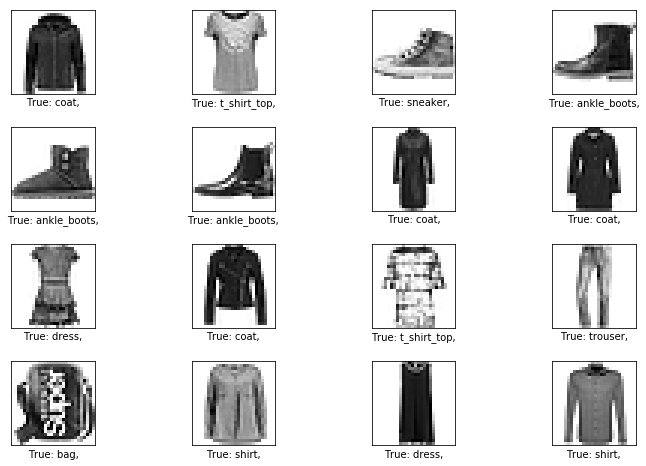

In [9]:
images = data.train.images[0:16]
class_true = data.train.cls[0:16]

# Plot using the function you made above
plt_image_labels(images=images, num_row=4, num_col=4, class_true=class_true)

## Define tensorflow graph

Tensorflow requires you to construct and computation graph first with placeholders and variables (to be optimized) before actually calculating the predictions. If you want to know more about the computational graph and classes used here, please refer to the official document [here](https://www.tensorflow.org/get_started/get_started).


In [10]:
# Define place holders. These are where your input and output goes when actually computing.
X = tf.placeholder(tf.float32, [None, IMG_TOT], name="X")
Y = tf.placeholder(tf.float32, [None, NUM_CLASSES], name="Y")
Y_true_class = tf.placeholder(tf.int64, [None], name="Y_true_class")

# Define variables. These variables are going to be optimized when computing.
W = tf.Variable(tf.truncated_normal([IMG_TOT, NUM_CLASSES], stddev=0.1), name="weights")
b = tf.Variable(tf.zeros([NUM_CLASSES]), name="biases")

Now we define a linear model.

In [11]:
# Defining a simple linear model Y_pred = WX + b
model = tf.add(tf.matmul(X, W), b)

# Use softmax layer to normalize the output and then get the highest number to determine the class
Y_pred = tf.nn.softmax(model)
Y_pred_class = tf.argmax(Y_pred, axis=1)

We also need to define a loss function.

In [12]:
# Define loss function. Least squared error
l2_sq = tf.reduce_mean(tf.multiply(0.5, tf.square(tf.subtract(model, Y))), axis=0, name="least_square")

And finally, we are going to define optimization method

In [13]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE).minimize(l2_sq, name="minimizer")

We also need to define performance measures

In [14]:
correct_prediction = tf.equal(Y_pred_class, Y_true_class)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Running tensorflow session

From here, we are going to run the tensorflow graph defined above. Usually, you put the above codes into functions and then from here, you execute the session. You could write the below codes into the main function.

At first, we are going to define a global variable initializer. Then, we define a tensorflow session and run everything inside. Usually, you log everything into the tensorboard and visualize the loss and the accuracy but those implementations will be explained in the folder named TF01_linear_model in the same github repository.

In [15]:
# Make sure that you never call this before creating a model since it requires that you have defined a graph already.
init = tf.global_variables_initializer()

# Running a tensorflow session
with tf.Session() as sess:
    print("Initializing all the variables.")
    sess.run(init)
    
    # Initialize some variables for logging results.
    # This will not be needed in python code where you use tensorboard.
    loss_record = [];
    train_record = [];
    
    print("Start training.")
    for i in range(NUM_EPOCHS):
        # Get a batch of training samples. Every time this is called within a loop,
        # it gets the next batch.
        x_batch, y_batch = data.train.next_batch(BATCH_SIZE)
        
        # Create a dict with batched samples. This will go into the optimizer to train the model.
        feed_dict_train = {X: x_batch, Y: y_batch}
        
        # Run the optimization and calculate the loss
        result_l, _ = sess.run([l2_sq, optimizer], feed_dict=feed_dict_train)
        mean_loss = np.mean(result_l)
        loss_record.append(mean_loss)
        
        # Also calculate the training accuracy
        y_batch_class = np.array([label.argmax() for label in y_batch])
        feed_dict_train_no_one_hot = {X: x_batch, Y_true_class: y_batch_class}
        acc_train = sess.run(accuracy, feed_dict=feed_dict_train_no_one_hot)
        train_record.append(acc_train)
        
        # Print the loss and the training accuracy every 10 iteration
        if i % BATCH_SIZE == 0:
            print("Loss function: %.4f" % mean_loss)
            print("Training accuracy: {0:>6.1%}".format(acc_train))
            
    print("Training finished.")
    
    print("\nStart testing.")
    # We are going to feed all the test samples
    feed_dict_test = {X: data.test.images,
                  Y: data.test.labels,
                  Y_true_class: data.test.cls}

    # Calculate the accuracy
    acc = sess.run(accuracy, feed_dict=feed_dict_test)

# Print the accuracy
print("Test accuracy: {0:.1%}".format(acc))

Initializing all the variables.
Start training.
Loss function: 0.9292
Training accuracy:   4.0%
Loss function: 0.1747
Training accuracy:   6.0%
Loss function: 0.1263
Training accuracy:  24.0%
Loss function: 0.1555
Training accuracy:  20.0%
Loss function: 0.1251
Training accuracy:  30.0%
Loss function: 0.1103
Training accuracy:  24.0%
Loss function: 0.1152
Training accuracy:  22.0%
Loss function: 0.0977
Training accuracy:  38.0%
Loss function: 0.1018
Training accuracy:  34.0%
Loss function: 0.1061
Training accuracy:  34.0%
Training finished.

Start testing.
Test accuracy: 35.7%


## Analyzing the results

From here, we are going to step in a bit to analyze the results. First, let's define some helper functions for plotting loss and training accuracy as well as examples of misclassified images.

In [24]:
# Defining a helper function to plot loss and accuracy.
# This part will be replaced with tensorboard in the python code tutorial in the same github repo.
def plot_loss_acc(loss_values, acc_values, loss_label, acc_label):
    
    # Create subplots for loss and accuracy. Sharing x axis as num epochs
    fig, axes = plt.subplots(2, sharex=True)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    axes[0].plot(loss_values)
    axes[0].set_ylabel(loss_label)
    
    axes[1].plot(acc_values)
    axes[1].set_ylabel(acc_label)

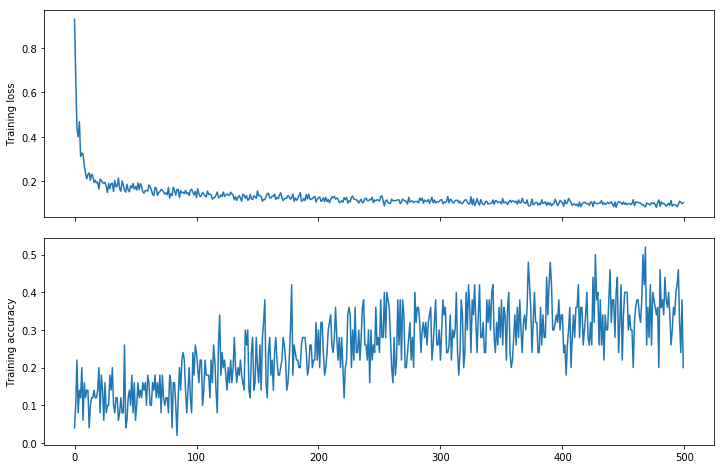

In [25]:
# Plotting training loss and accuracy to see how well the model was trained
plot_loss_acc(loss_record, train_record, 'Training loss', 'Training accuracy')

We can see that the loss has dropped significantly in the first 30 epochs and stabilizes. The training accuracy is noisy but constantly increasing. Note that we haven't taken any steps to avoid over-fitting problem just yet, but it's generally a first step to make the model over-fit first and then move on to the next step. Otherwise, you might be having some other problems that won't even let you over-fit.